In [34]:
import pandas as pd
import sqlite3

# Importing smaller movie_metedata via csv
# movies = pd.read_csv("movie_metadata.csv")
# movies.head()

# read movie data table from db into dataframe
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.head()
# Checking for duplicates...
movies['imdb_num_code'].value_counts()

tt0130018    1
tt2183034    1
tt0119925    1
tt1764234    1
tt0282209    1
tt0780511    1
tt0274558    1
tt0433383    1
tt0165710    1
tt3691740    1
tt0160399    1
tt0417976    1
tt0163025    1
tt0134618    1
tt1160368    1
tt0418647    1
tt0258273    1
tt1571222    1
tt0455590    1
tt0925248    1
tt0308208    1
tt0104839    1
tt0138304    1
tt1449283    1
tt0161081    1
tt0146336    1
tt0285462    1
tt1538403    1
tt0093378    1
tt0114614    1
            ..
tt0490204    1
tt0338216    1
tt1690953    1
tt0340855    1
tt0110912    1
tt0058331    1
tt0345061    1
tt0102713    1
tt1012804    1
tt0252299    1
tt0032138    1
tt0118771    1
tt0821642    1
tt0117958    1
tt1517260    1
tt0245674    1
tt1504320    1
tt1148165    1
tt0337741    1
tt0087298    1
tt0093300    1
tt0106226    1
tt0365885    1
tt0280707    1
tt0947802    1
tt0151804    1
tt0200027    1
tt0218043    1
tt0165929    1
tt0118928    1
Name: imdb_num_code, Length: 3637, dtype: int64

In [ ]:
# Print list of columns in smaller movies dataframe, in alphabetical order
for col in movies.columns.sort_values().values:
    print (col)

In [ ]:
movies_large = pd.read_csv('movies_metadata.csv')
movies_large = movies_large.set_index('imdb_id')
movies_large.head()

In [ ]:
for col in movies_large.columns.sort_values().values:
    print (col)

In [ ]:
movies.describe()
# Originally was ~4,900-5,100 records before re-pulling the data on 6/23 @ 8:21 pm...
# Believe it is because Seth dropped all N/A values
# New record count is not 3,738

In [ ]:
movies_large.describe()

In [ ]:
# Converting popularity from type 'object' to type 'numeric' (float)
movies['popularity'] = pd.to_numeric(movies['popularity'])
# Checking counts and types...nothing has changed.  
# Actually, there appears to be two more records now.  Why?
movies.describe()

In [ ]:
# Create new dataframe with just the production companies and genres from large dataset
movies_large_pc = movies_large[["production_companies","genres"]]
movies_large_pc.head()

In [ ]:
# Counting the number of production companies and genres per movie
movies_large_pc['production_companies_count'] = movies_large_pc['production_companies'].str.count('id')
movies_large_pc['genres_count'] = movies_large_pc['genres'].str.count('name')
movies_large_pc.head()

In [ ]:
# Add new columns to the existing movies table in sqllite db

# Columns straight from large dataset
movies = movies.merge(movies_large_pc[['production_companies_count','genres_count']], left_on="imdb_num_code", right_index=True, how="inner")
# Calculated columns based on occurrences of strings in certain columns
movies = movies.merge(movies_large[['popularity','vote_count','vote_average']], left_on="imdb_num_code", right_index=True, how="inner")
movies

# Definitions of new fields:

# Popularity: (Undetermined at this point on how this is calculated) - appears to be 0 to 100 rating scale.
# Vote Count: Number of users that voted for the movie on the TMDB website.
# Vote Average: Average score from the aforementioned votes.  
# Production Companies Count: Number of production companies that were a part of developing the movie.
# Genres Count: Number of genre classifications assigned to each movie.

# Website for large dataset:
# https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv



In [ ]:
# Code to drop dups if the above cell is written multiple times
# movies = movies.drop(['popularity_x','vote_count_x','vote_average_x','production_companies_count_x',
#                     'genres_count_x','production_companies_count_y','genres_count_y','popularity_y',
#                     'vote_count_y','vote_average_y'],axis=1)


In [ ]:
# Seem to be duplicate records now...
movies['imdb_num_code'].value_counts()

# Also, why is there 128 duplicate records for tt0157472?

In [ ]:
# Remove duplicates
# removeDups2_movies = movies.drop_duplicates(subset ="imdb_num_code", 
#                      keep = 'first', inplace = True) 

In [ ]:
movies

##########################################

# Modelling

##########################################

## AdaBoost

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.sort_index(1).head()

,actor_1_facebook_likes,actor_1_name,actor_1_score,actor_2_facebook_likes,actor_2_name,actor_2_score,actor_3_facebook_likes,actor_3_name,actor_3_score,aspect_ratio,budget,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,director_score,duration,facenumber_in_poster,genres,genres_count,gross,gross_margin,holiday_month,imdb_num_code,imdb_score,language,movie_facebook_likes,movie_imdb_link,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,popularity,production_companies_count,rating_numeric,release_date,release_month,revenue,success_bins,successful,title_year,tot_noms,tot_wins,total_actor_starpower,vote_average,vote_count
0,1000.0,CCH Pounder,1.520767,936.0,Joel David Moore,1.747604,855.0,Wes Studi,2.066294,1.78,237000000.0,4834,Color,PG-13,USA,0.0,James Cameron,3.091853,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,4,760505847.0,0.688365,1,tt0499549,7.9,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,185.070892,4.0,3,2009-12-10,12,523505847.0,extreme success,1,2009.0,0,0,5.334665,7.2,12114.0
1,3000.0,Djimon Hounsou,3.041534,1000.0,Jason Flemyng,5.825346,855.0,Wes Studi,2.066294,2.35,45000000.0,6558,Color,R,USA,208.0,Stephen Sommers,1.766773,106.0,0.0,Action|Adventure|Horror|Sci-Fi,4,11146409.0,-3.037175,0,tt0118956,6.0,English,0,http://www.imdb.com/title/tt0118956/?ref_=fn_t...,Deep Rising,106.0,273.0,26551,creature feature|hijacker|ocean|ship|shot in t...,6.922458,3.0,4,1998-01-30,01,-33853591.0,no success,0,1998.0,0,0,10.933174,6.0,155.0
2,23000.0,Christian Bale,8.364217,909.0,Michael Greyeyes,0.582535,855.0,Wes Studi,2.066294,2.35,30000000.0,27829,Color,PG-13,USA,0.0,Terrence Malick,1.325080,150.0,0.0,Biography|Drama|History|Romance,3,12712093.0,-1.359958,1,tt0402399,6.7,English,0,http://www.imdb.com/title/tt0402399/?ref_=fn_t...,The New World,222.0,671.0,70771,captain|fort|love|native american|trade,7.694502,5.0,3,2005-12-25,12,-17287907.0,no success,0,2005.0,0,0,11.013046,6.4,336.0
3,21000.0,Robert Downey Jr.,9.884984,936.0,Joel David Moore,1.747604,722.0,Kristin Davis,2.066294,2.35,50000000.0,24664,Color,PG,USA,48.0,Brian Robbins,2.650160,98.0,0.0,Comedy|Family|Fantasy,2,61112916.0,0.181842,0,tt0393735,4.4,English,747,http://www.imdb.com/title/tt0393735/?ref_=fn_t...,The Shaggy Dog,76.0,83.0,14888,animal as human|dog movie|elevator|human becom...,4.878907,3.0,2,2006-03-09,03,11112916.0,moderate success,1,2006.0,1,0,13.698882,4.5,138.0
4,14000.0,Josh Hutcherson,2.661342,12000.0,Dwayne Johnson,1.747604,722.0,Kristin Davis,2.066294,1.85,79000000.0,27842,Color,PG,USA,62.0,Brad Peyton,1.325080,94.0,3.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,3,103812241.0,0.239011,0,tt1397514,5.8,English,0,http://www.imdb.com/title/tt1397514/?ref_=fn_t...,Journey 2: The Mysterious Island,178.0,133.0,67296,gold|hurricane|island|mountain|mysterious island,9.46307,3.0,2,2012-01-19,01,24812241.0,average success,1,2012.0,0,0,6.475240,5.8,1050.0


In [3]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [33]:
# Load data
data = movies  [[
    
#                 "rating_numeric","director_score","production_companies_count",
#                 "total_actor_starpower","release_month","tot_wins","tot_noms"
    
#                 "director_facebook_likes", "cast_total_facebook_likes",
#                 "director_score","duration","facenumber_in_poster","genres_count",
#                 "holiday_month","imdb_score","movie_facebook_likes","production_companies_count",
#                 "rating_numeric","tot_noms","tot_wins","total_actor_starpower","vote_average"
    
                # Agreed upon 9 features - can be found and used in prediction before movie release
                'duration','rating_numeric', 'director_score','production_companies_count',
                "holiday_month","tot_wins","tot_noms", "total_actor_starpower"


                ]]

to_predict = movies [["successful"]]
X = data
y = to_predict

In [5]:
# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [6]:
# define hyper parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

In [7]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# The most important parameters are base_estimator, n_estimators, and learning_rate.

# base_estimator: It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
# n_estimators: Number of weak learners to train iteratively.
# learning_rate: It contributes to the weights of weak learners. It uses 1 as a default value.

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5741758241758241


In [9]:
# Using Different Base Learners
# You can use any ML learner as base estimator if it accepts sample weight such as Decision Tree, Support Vector Classifier.

# # Load libraries
# from sklearn.ensemble import AdaBoostClassifier

# # Import Support Vector Classifier
# from sklearn.svm import SVC
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics

# svc=SVC(probability=True, kernel='poly')

# # Create adaboost classifer object
# abc = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# # Train Adaboost Classifer
# model = abc.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = model.predict(X_test)

# # Grid Search
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import roc_curve, roc_auc_score

# # ROC Curve (Receiving Operator Characteristic)
# grid_search_ABC = GridSearchCV(abc, param_grid=params, scoring = 'roc_auc') 


# Model Accuracy, how often is the classifier correct?
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [10]:
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

<Figure size 1332x756 with 0 Axes>

### Feature Importance - AdaBoost Model

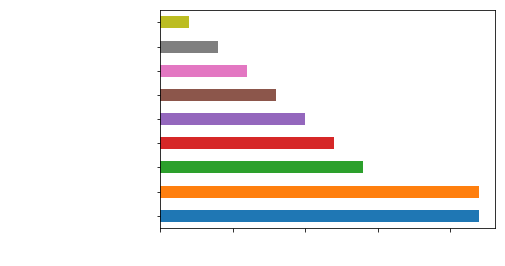

<Figure size 720x576 with 0 Axes>

In [11]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
label = plt.xlabel("Features")
label.set_color("white")
[i.set_color("white") for i in plt.gca().get_xticklabels()]
[i.set_color("white") for i in plt.gca().get_yticklabels()]
plt.figure(figsize=(10,8))
plt.show()



In [ ]:
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

### AdaBoost with Principle Component Analysis (PCA) 

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

In [25]:
# define model; CHANGE FOR YOUR MODEL
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
# Function to test PCA with a range of component values

for n in range(2,10):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test),"")

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=2 0.5128205128205128 
n=3 0.5128205128205128 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=4 0.565018315018315 
n=5 0.5531135531135531 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=6 0.565018315018315 
n=7

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.5659340659340659 
n=8 0.5769230769230769 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=9 0.5833333333333334 


In [27]:
pca.explained_variance_

array([4.54777922e+02, 2.36211844e+01, 1.12129250e+01, 4.73916335e+00,
       4.37798168e+00, 2.98943705e+00, 7.67060907e-01, 9.30487689e-02,
       8.41479831e-02])

In [ ]:
# import numpy as np
# i = np.identity(len(X_train[0]))
# i
# pd.DataFrame(pca.transform(i))
# These column names are equivalent to rows 0-9 in pca.transform above
# movies.columns

### AdaBoost PCA with Scaled X_train and X_test data

In [29]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [30]:
# define model; CHANGE FOR YOUR MODEL
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_scaled, y_train)

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
# Function to test PCA with a range of component values

for n in range(2,10):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train_scaled, y_train)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test),"")

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=2 0.5338827838827839 
n=3 0.5183150183150184 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=4 0.5412087912087912 
n=5 0.5375457875457875 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=6 0.5457875457875457 
n=7 0.5531135531135531 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=8 0.5540293040293041 


C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=9 0.5485347985347986 


In [32]:
X

,duration,rating_numeric,director_score,production_companies_count,release_month,holiday_month,tot_wins,tot_noms,total_actor_starpower
0,178.0,3,3.091853,4.0,12,1,0,0,5.334665
1,106.0,4,1.766773,3.0,01,0,0,0,10.933174
2,150.0,3,1.325080,5.0,12,1,0,0,11.013046
3,98.0,2,2.650160,3.0,03,0,0,1,13.698882
4,94.0,2,1.325080,3.0,01,0,0,0,6.475240
5,146.0,4,0.441693,4.0,05,0,1,2,3.409212
6,90.0,3,2.650160,1.0,09,0,0,0,2.816560
7,121.0,4,2.208466,1.0,11,1,0,0,6.499734
8,101.0,4,0.883387,8.0,08,0,0,0,3.409212
9,110.0,4,0.883387,4.0,08,0,0,0,3.409212
